# Project D - Severstal Steel Defect Detection Kaggle Competition 
## Semantic Segmentation of steel defects
### Authors: Utkrisht Rajkumar, Subrato Chakravorty, Chi-Hsin Lo

This is the demo file used to qualitatively evaluate our models on validation and test images.

In [1]:
import os
import json
import gc
import cv2
# import tensorflow.python.keras
from tensorflow.python.keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import sys
from data_gen import DataGenerator
import pickle

## Load Model

In [2]:
from utils import dice_coef, bce_dice, post_process
from model import relu6

In [8]:
model_path = './models/unet.h5'
cb={'bce_dice': bce_dice, 'dice_coef': dice_coef, 'relu6':relu6, 'tf':tf}
unet = load_model(model_path, custom_objects=cb)

model_path = './models/unet_res.h5'
unet_res = load_model(model_path, custom_objects=cb)

model_path = './models/unet_invres.h5'
unet_invres = load_model(model_path, custom_objects=cb)
model_path = './models/deeplabv3.h5'
deeplab = load_model(model_path, custom_objects=cb)

In [4]:
models = [unet, unet_res, unet_invres, deeplab]

## Qualitative results on validation images

Load 4 validation images and their ground truths and predict using all 4 models.

image idx:  11


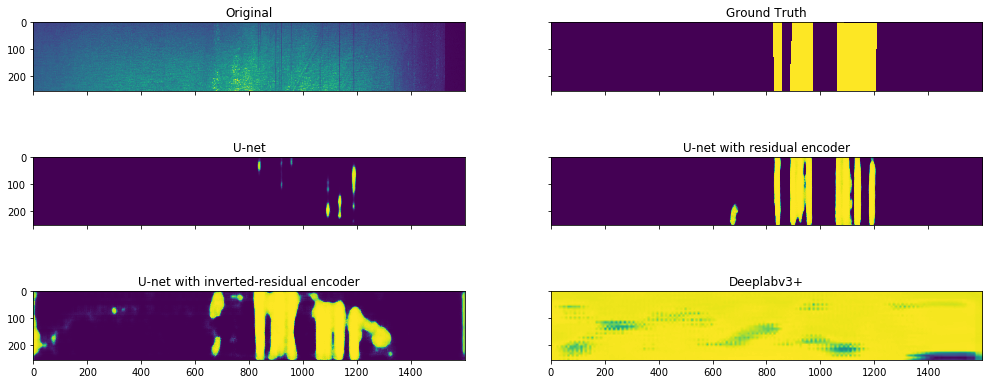

image idx:  12


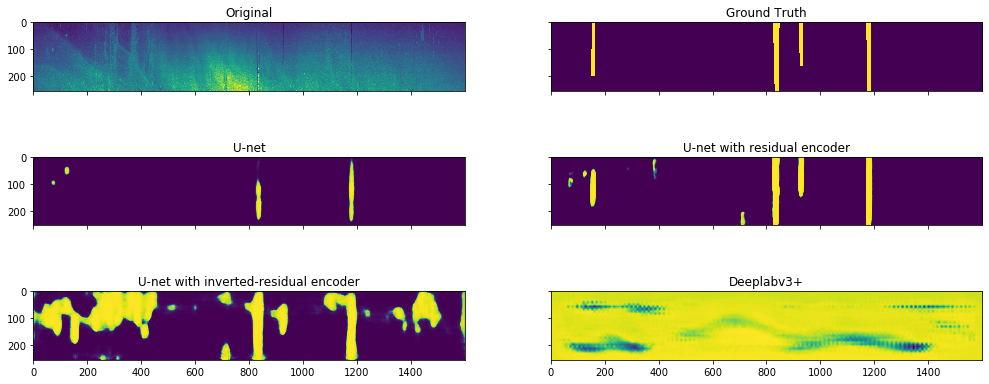

image idx:  13


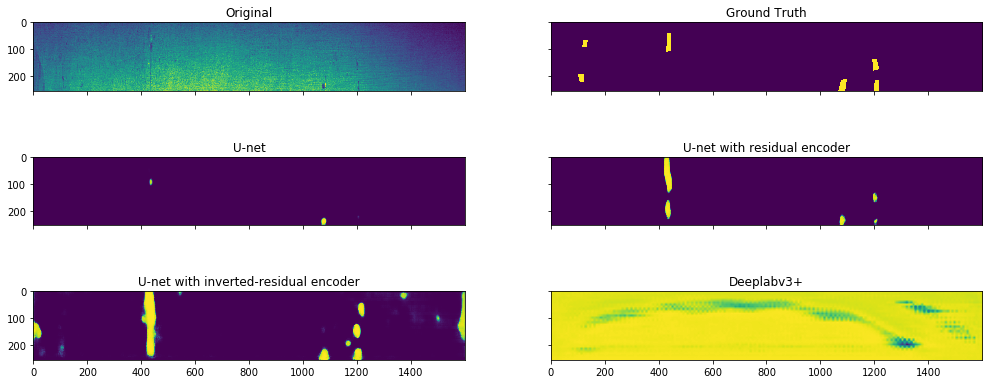

image idx:  14


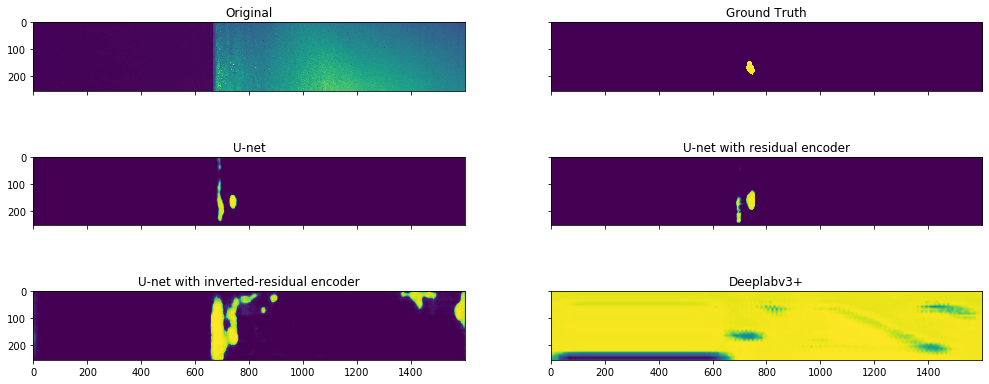

image idx:  15


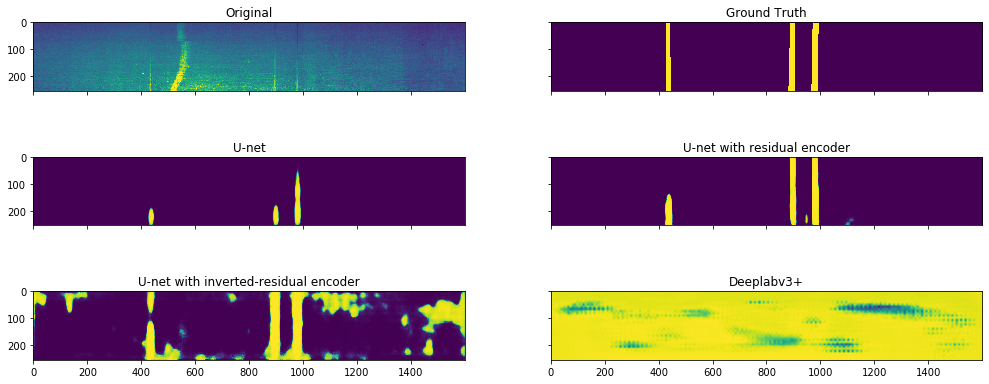

image idx:  16


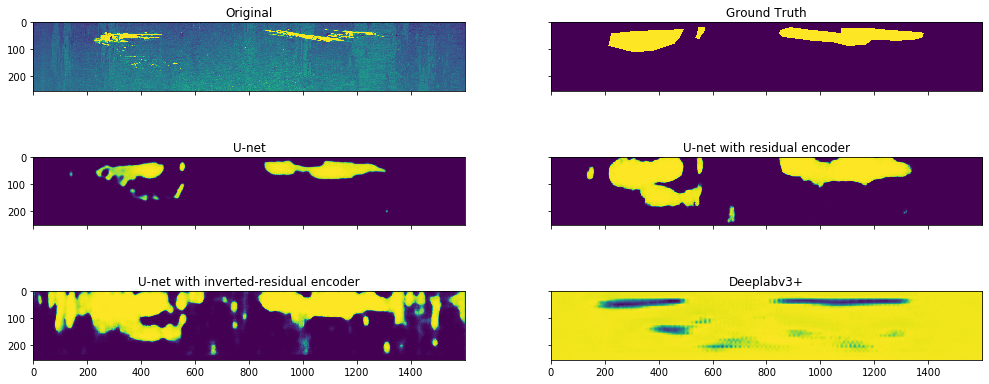

In [5]:
for idx in [11, 12, 13, 14, 15, 16]:
    print('image idx: ', idx)
    fig, ax = plt.subplots(3,2, figsize=(17,7), sharex=True, sharey=True)
    path = './ex_images/val_'+str(idx)+'.pickle'
    with open(path, 'rb') as f:
        test = pickle.load(f)
    ax[0,0].imshow(np.squeeze(test[0]))
    ax[0,1].imshow(np.sum(test[1], axis=-1))
    preds = [model.predict(np.expand_dims(test[0], axis=0)) for model in models]
    ax[1,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[1,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[2,0].imshow(np.squeeze(preds[2])[...,2])
    ax[2,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('Original'); ax[0,1].set_title('Ground Truth'); ax[1,0].set_title('U-net');ax[1,1].set_title('U-net with residual encoder')
    ax[2,0].set_title('U-net with inverted-residual encoder'); ax[2,1].set_title('Deeplabv3+')
    plt.show()

All three U-net architectures perform well when evaluated qualitatively by visualizing segmentation maps on samples from validation data set.  It is clear from the above figures that U-net with residual blocks gives better segmentation maps in terms of minimum false positives and false negatives when compared to other two U-net architectures. The base U-net architecture seems to be very conservative in deciding whether a pixel is a defect or not. Therefore, it makes less false positive errors but ends up increasing number of false negatives. Whereas, U-net with inverted residual blocks learns to do the exact opposite. It is very lenient in deciding whether a pixel is defect or not, therefore, although it finds most of the true positives but ends up making a lot of false positive errors. U-net with residual encoder seems to be able to strike the perfect balance between the making less false positive and less false negatives. Consequently, it performs better than both the models.
See report for the analysis of our qualitative examples.   
**Performance of DeepLab-v3+ was expected from the training and validation plots as it was evident that the model wasn't learning anything.


## Contradiction between ground truth and prediction (Noisy labels)

image idx:  17


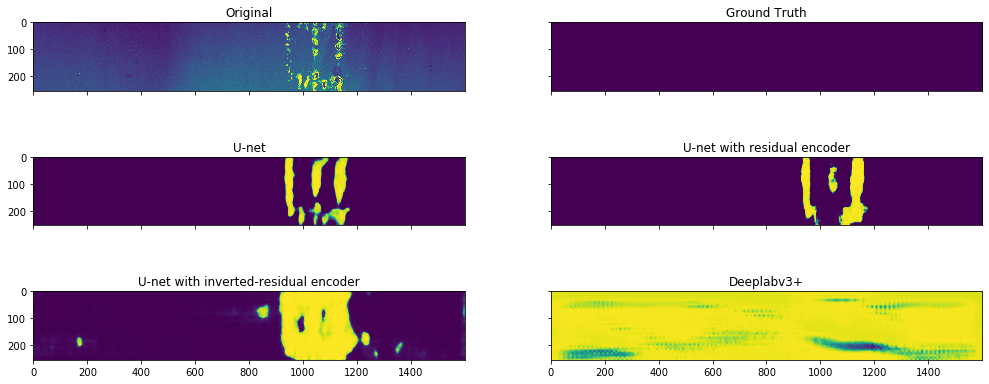

In [6]:
for idx in [17]:
    print('image idx: ', idx)
    fig, ax = plt.subplots(3,2, figsize=(17,7), sharex=True, sharey=True)
    path = './ex_images/val_'+str(idx)+'.pickle'
    with open(path, 'rb') as f:
        test = pickle.load(f)
    ax[0,0].imshow(np.squeeze(test[0]))
    ax[0,1].imshow(np.sum(test[1], axis=-1))
    preds = [model.predict(np.expand_dims(test[0], axis=0)) for model in models]
    ax[1,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[1,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[2,0].imshow(np.squeeze(preds[2])[...,2])
    ax[2,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('Original'); ax[0,1].set_title('Ground Truth'); ax[1,0].set_title('U-net');ax[1,1].set_title('U-net with residual encoder')
    ax[2,0].set_title('U-net with inverted-residual encoder'); ax[2,1].set_title('Deeplabv3+')
    plt.show()

We can see that the ground truth values in the training set are somewhat misleading for some samples. In the above sample, we can see, in the original image, clear marks that can be categorized as defects as similar marks in other images have been classified as defects. But the ground truth does not contain any defect. Nevertheless, U-net and ResUnet are able to identify and classify them as defects as seen in corresponding segmentation maps.

## Qualitative results on test images

Load 4 test images and show prediction results

image idx:  30


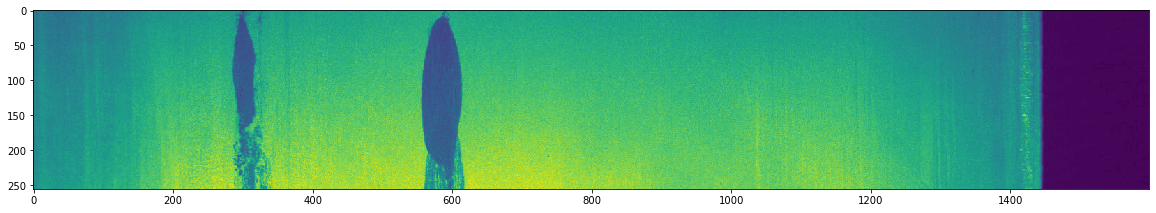

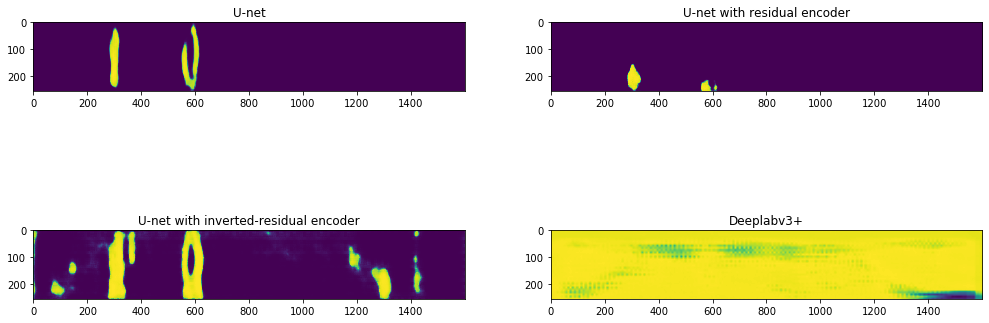

image idx:  20


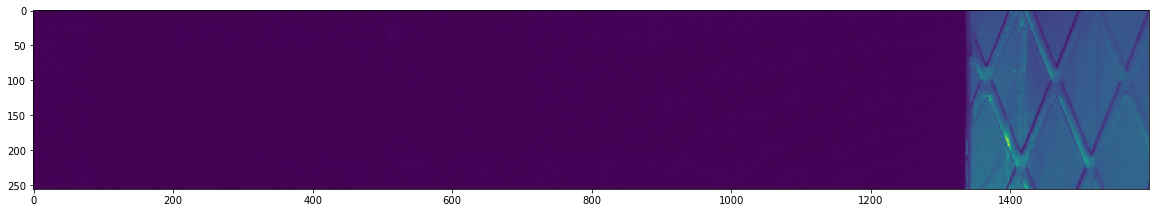

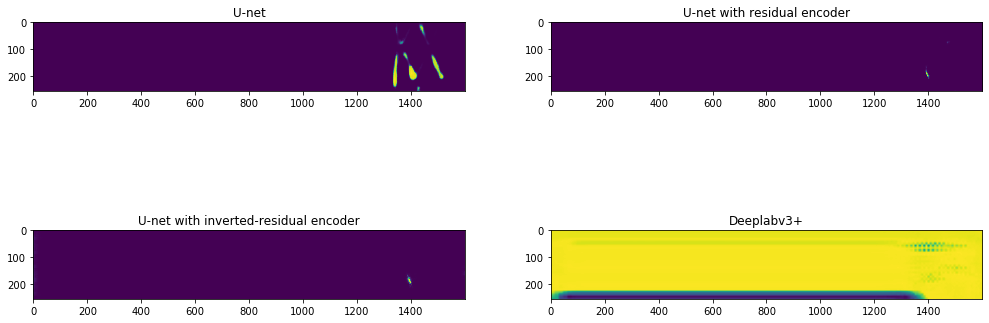

image idx:  40


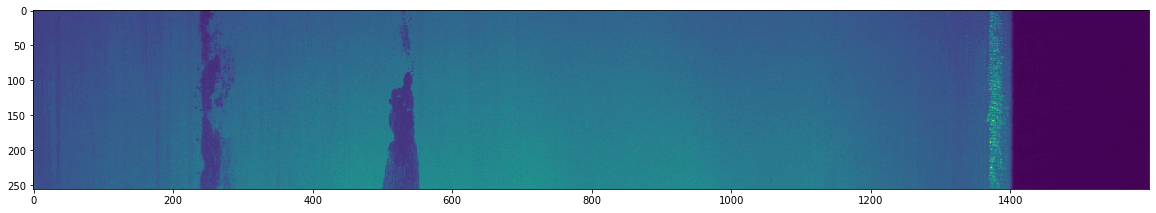

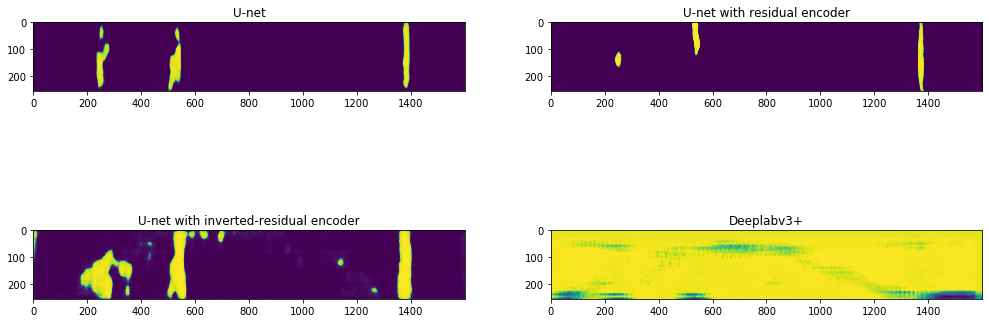

image idx:  70


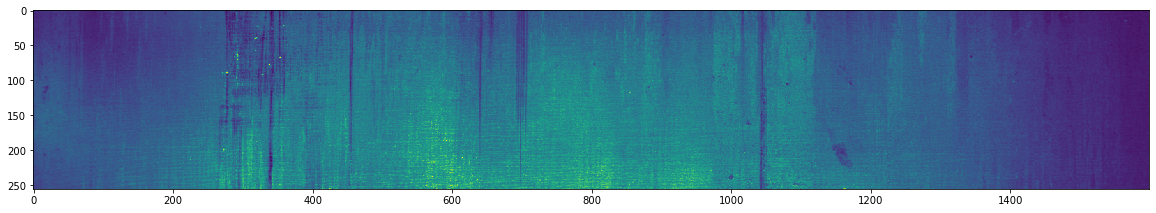

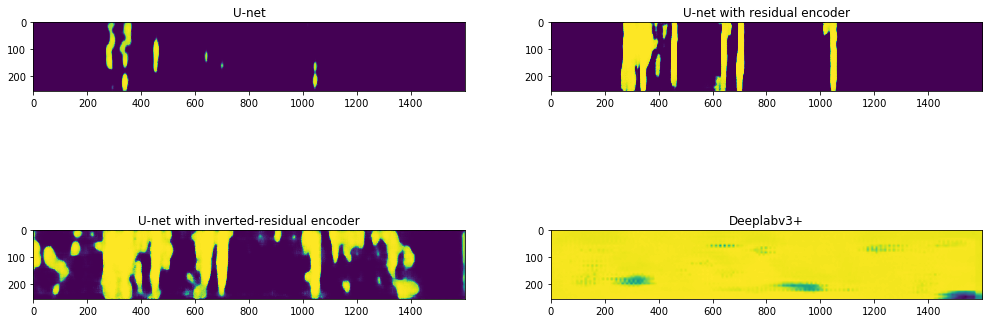

In [7]:
for idx in [30, 20, 40, 70]:
    print('image idx: ', idx)
    path = './ex_images/' + str(idx) + '.npy'
    test = np.load(path)
    plt.figure(figsize=(20,10)); plt.imshow(np.squeeze(test)); plt.show()
    fig, ax = plt.subplots(2,2, figsize=(17,7))
    preds = [model.predict(np.expand_dims(test, axis=0)) for model in models]
    ax[0,0].imshow(np.squeeze(preds[0])[...,2]) 
    ax[0,1].imshow(np.squeeze(preds[1])[...,2]) 
    ax[1,0].imshow(np.squeeze(preds[2])[...,2])
    ax[1,1].imshow(np.squeeze(preds[3])[...,2])
    ax[0,0].set_title('U-net');ax[0,1].set_title('U-net with residual encoder')
    ax[1,0].set_title('U-net with inverted-residual encoder'); ax[1,1].set_title('Deeplabv3+')
    plt.show()

Since, we don't have the ground truth for the test images, we are unable to do a credible analysis of the results. But, on visual inspection it can be seen that three unet models especially U-net and ResUnet are able to identify patterns which may seem as defects to a naked eye.